In [2]:
from networkx import adjacency_matrix, all_neighbors, karate_club_graph
from scipy.sparse import dia_matrix
from numpy import copy, full, zeros, array
from numpy.linalg import norm
from random import choice, random, sample

from numpy import set_printoptions
from sys import maxsize

In [4]:
def simulateInfection(G, src, model='SI', lamda=0.3, runtime=1000, threshold=0.3):
    N = G.number_of_nodes()
    infected_nodes = {src}

    for i in range(runtime):
        temp_infected = infected_nodes.copy()

        for node in infected_nodes:
            for neighbour in all_neighbors(G, node):
                if random() < lamda:
                    temp_infected.add(neighbour)

        infected_nodes = temp_infected

        if len(infected_nodes) > threshold * N:
            break

    y = full(N, -1)
    for infNode in infected_nodes:
        y[nodes.index(infNode)] = 1

    return y

In [5]:
def labelRankingScore(G, y, alpha=0.5):
    N = G.number_of_nodes()

    W = adjacency_matrix(G)
    diag_elem = W.sum(axis=1).A1 ** (-0.5)

    inv_sqrt_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())
    S = inv_sqrt_D @ W @ inv_sqrt_D

    f = copy(y)

    while True:
        f_ = alpha * S @ f + (1 - alpha) * y

        if norm(f - f_) < 0.001 * N: # Convergence Criteria
            break

        f = f_

    return f

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

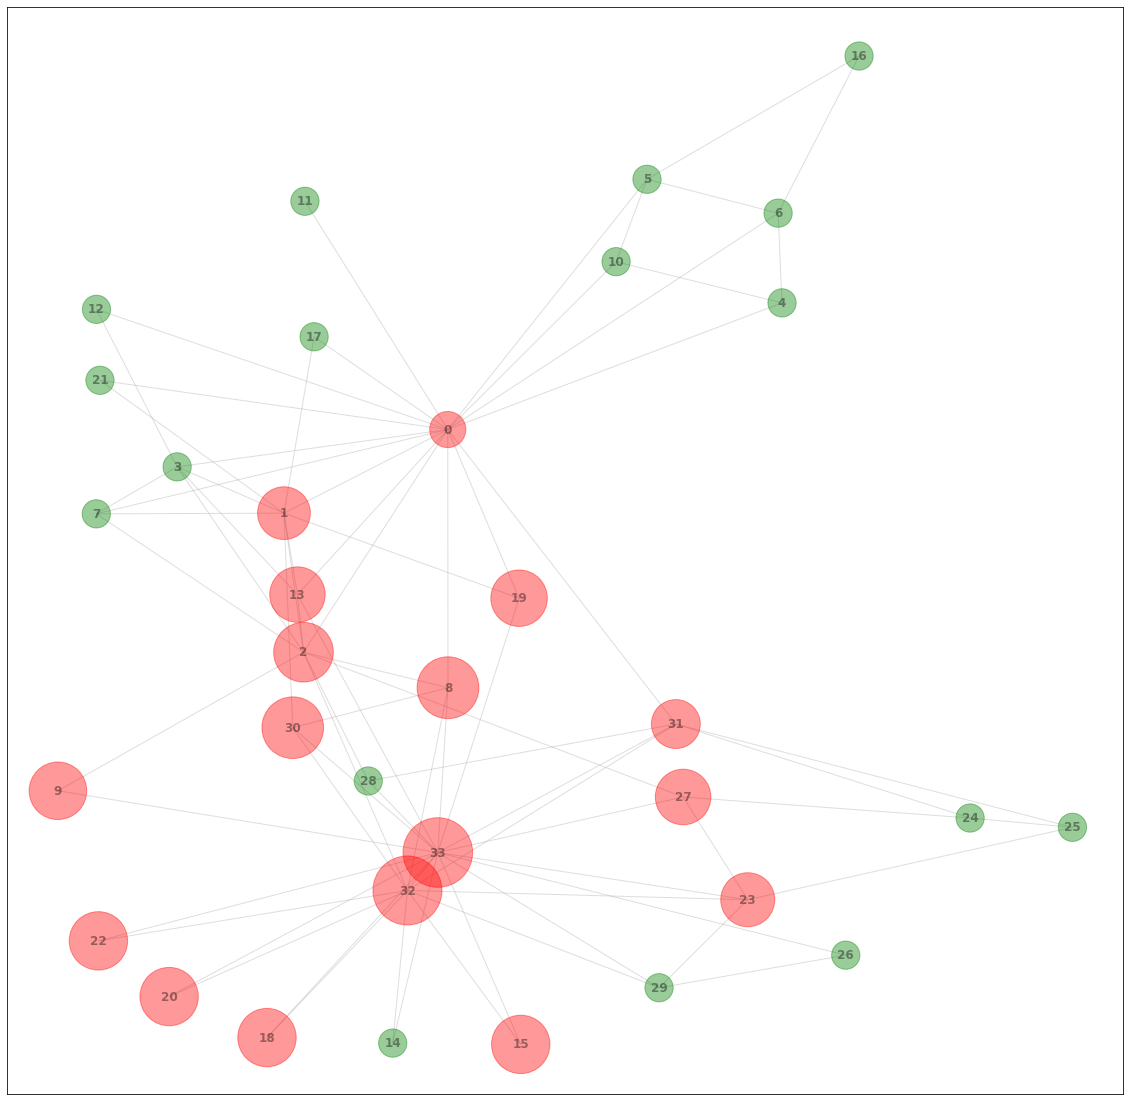

Actual Source: 18
Predicted Source: 33


In [22]:
G = karate_club_graph()
src = choice(list(G.nodes()))

y = simulateInfection(G, src)
f = labelRankingScore(G, y)

detected_src_idx = max(enumerate(f), key=lambda x: x[1])
detected_src = list(G.nodes())[detected_src_idx[0]]

fig, ax = plt.subplots(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.2, seed=42)
size = [v * 5000 if v > 0 else 800 for v in f]
color = ['green' if n < 0 else 'red' for n in f]

nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_color=color,
        node_size=size,
        edge_color="#adadad",
        alpha=0.4,
        font_weight='bold')

plt.show()


print(f'Actual Source: {src}\n'
      f'Predicted Source: {detected_src}')

In [26]:
# knownDict = {
#   infected: [nodes],
#   safe: [nodes]
# }

def simulatePartialInfection(
    G, src, model='SI', lamda=0.3,
    runtime=1000, threshold=0.3, sampling=0.7
):
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    infected_nodes = {src}

    for i in range(runtime):
        temp_infected = infected_nodes.copy()

        for node in infected_nodes:
            for neighbour in all_neighbors(G, node):
                if random() < lamda:
                    temp_infected.add(neighbour)

        infected_nodes = temp_infected

        if len(infected_nodes) > threshold * N:
            break

    snapshot = sample(nodes, int(sampling * len(nodes)))
    known_dict = {
        'infected': [],
        'safe': []
    }

    for node in snapshot:
        if node in infected_nodes:
            known_dict['infected'].append(node)
        else:
            known_dict['safe'].append(node)

    return known_dict

In [18]:
def resetF(F, known_dict):
    for node in known_dict['safe']:
        F[node][0] = 1
        F[node][1] = 0

    for node in known_dict['infected']:
        F[node][0] = 0
        F[node][1] = 1

def GFGH(G, known_dict):
    N = G.number_of_nodes()
    W = adjacency_matrix(G)

    diag_elem = 1 / W.sum(axis=1).A1
    inv_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())

    P = inv_D @ W
    F = zeros((N, 2))

    resetF(F, known_dict)
    prev_diff = 0

    while True:
        F_ = P @ F
        curr_diff = sum(sum(abs(F - F_))) # Convergence Criteria

        resetF(F, known_dict)

        if curr_diff < 0.0001 * N:
            break

        F = F_

    O = array([1 if f[1] > f[0] else -1 for f in F])
    return O

def LGC(G, known_dict, alpha):
    N = G.number_of_nodes()
    W = adjacency_matrix(G)

    diag_elem = W.sum(axis=1).A1 ** (-0.5)
    inv_sqrt_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())

    S = inv_sqrt_D @ W @ inv_sqrt_D
    F = zeros((N, 2))

    resetF(F, known_dict)
    Y = copy(F)

    while True:
        F_ = alpha * S @ F + (1 - alpha) * Y

        if sum(sum(abs(F - F_))) < 0.0001 * N: # Convergence Criterion
            break

        F = F_

    O = array([1 if f[1] > f[0] else -1 for f in F])
    return O

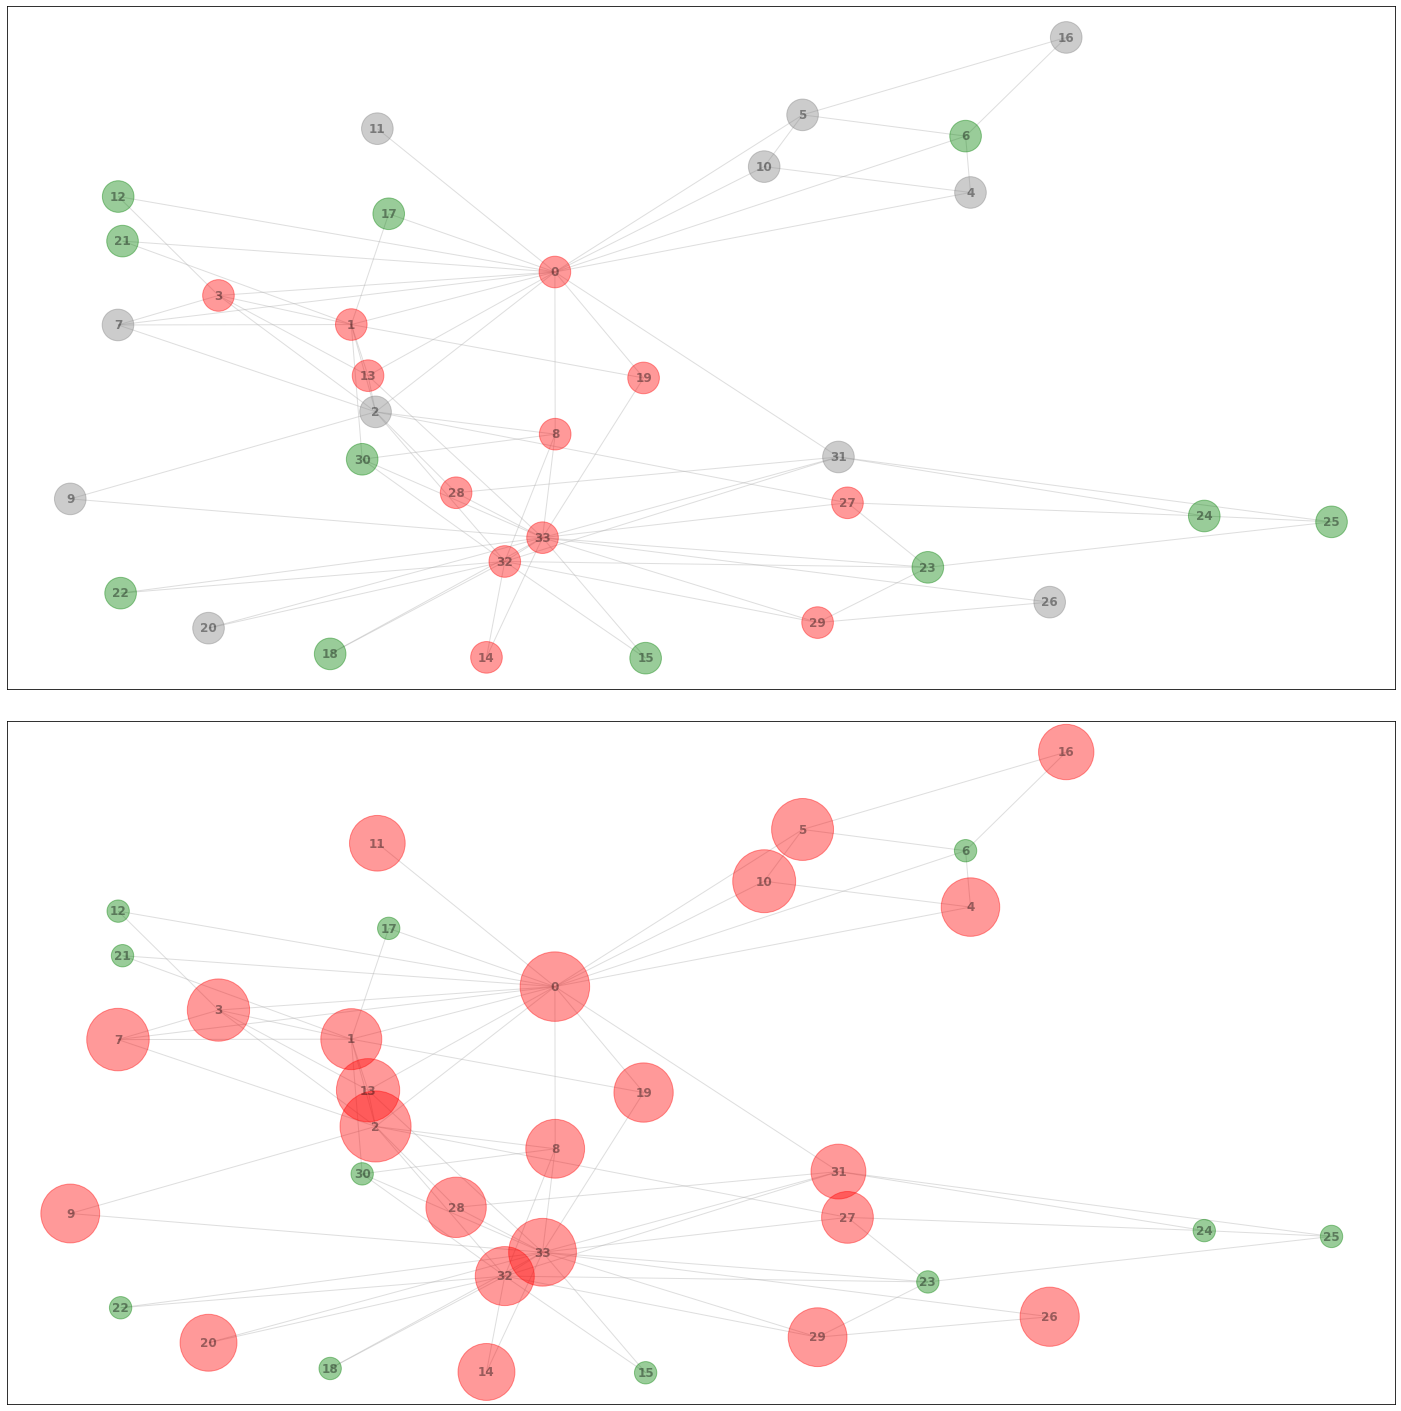

Actual Source: 2
Predicted Source: 2


In [32]:
G = karate_club_graph()
src = choice(list(G.nodes()))
N = G.number_of_nodes()

known_dict = simulatePartialInfection(G, src)
O = GFGH(G, known_dict)
f = labelRankingScore(G, O)

detected_src_idx = max(enumerate(f), key=lambda x: x[1])
detected_src = list(G.nodes())[detected_src_idx[0]]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 20))
fig.tight_layout()

pos = nx.spring_layout(G, k=0.2, seed=42)
size = [v * 5000 if v > 0 else 500 for v in f]

color1 = ['green' if n in known_dict['safe'] else
          'red' if n in known_dict['infected'] else
          'gray' for n in G.nodes]

color2 = ['green' if n < 0 else 'red' for n in f]

nx.draw_networkx( # Partial Graph snapshot
        G, 
        ax=ax1,
        pos=pos,
        with_labels=True,
        node_color=color1,
        node_size=1000,
        edge_color="#adadad",
        alpha=0.4,
        font_weight='bold')

nx.draw_networkx( # Predicted Graph
        G,
        ax=ax2,
        pos=pos,
        with_labels=True,
        node_color=color2,
        node_size=size,
        edge_color="#adadad",
        alpha=0.4,
        font_weight='bold')

plt.show()


print(f'Actual Source: {src}\n'
      f'Predicted Source: {detected_src}')